Load and Inspect Dataset

In [21]:
import pandas as pd

# Load the dataset
file_path = 'Cleaned_Blood_Glucose_Data.xlsx'
data = pd.read_excel(file_path)

# Display dataset overview
print("Dataset Overview:")
print(data.head())
print("\nDataset Information:")
data.info()

# Check for missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())

Dataset Overview:
   Age  Blood Glucose Level(BGL)  Diastolic Blood Pressure  \
0    9                        79                        73   
1    9                        80                        73   
2    9                        70                        76   
3    9                        70                        78   
4   66                       100                        96   

   Systolic Blood Pressure  Heart Rate  Body Temperature  SPO2  \
0                      118          98         98.300707    99   
1                      119         102         98.300707    94   
2                      110          81         98.300707    98   
3                      115          96         98.300707    96   
4                      144          92         97.807052    98   

   Sweating  (Y/N)  Shivering (Y/N) Diabetic/NonDiabetic (D/N)  
0                0                0                          N  
1                1                0                          N  
2                

Data Cleaning

In [22]:
# Rename columns for clarity
data.rename(columns={'Blood Glucose Level(BGL)': 'Glucose_Level',
                     'Diabetic/NonDiabetic (D/N)': 'Diabetic_Status'}, inplace=True)

# Handle missing values with median imputation
for col in data.select_dtypes(include='number').columns:
    data[col].fillna(data[col].median(), inplace=True)

# Drop duplicates
data.drop_duplicates(inplace=True)

print("\nCleaned Dataset:")
print(data.head())


Cleaned Dataset:
   Age  Glucose_Level  Diastolic Blood Pressure  Systolic Blood Pressure  \
0    9             79                        73                      118   
1    9             80                        73                      119   
2    9             70                        76                      110   
3    9             70                        78                      115   
4   66            100                        96                      144   

   Heart Rate  Body Temperature  SPO2  Sweating  (Y/N)  Shivering (Y/N)  \
0          98         98.300707    99                0                0   
1         102         98.300707    94                1                0   
2          81         98.300707    98                1                0   
3          96         98.300707    96                1                0   
4          92         97.807052    98                0                0   

  Diabetic_Status  
0               N  
1               N  
2             

<ipython-input-22-768cb2f3f46e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


Outlier Detection and Removal

In [23]:
from scipy.stats import zscore
import numpy as np

# Remove outliers based on Z-scores
z_scores = np.abs(zscore(data.select_dtypes(include='number')))
outlier_threshold = 3
data_no_outliers = data[(z_scores < outlier_threshold).all(axis=1)]

print(f"Outliers Removed: {len(data) - len(data_no_outliers)}")
data = data_no_outliers

Outliers Removed: 1122


New Feature Engineering

In [24]:
# Add new derived features
data['Glucose_to_BloodPressure'] = data['Glucose_Level'] / data['Systolic Blood Pressure']
data['HeartRate_to_Age'] = data['Heart Rate'] / data['Age']
data['BloodPressure_Difference'] = data['Systolic Blood Pressure'] - data['Diastolic Blood Pressure']

# Encode age group
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 18, 45, 60, 100], labels=['Child', 'Young Adult', 'Middle Age', 'Senior'])

print("\nDerived Features:")
print(data[['Glucose_to_BloodPressure', 'HeartRate_to_Age', 'BloodPressure_Difference', 'Age_Group']].head())


Derived Features:
   Glucose_to_BloodPressure  HeartRate_to_Age  BloodPressure_Difference  \
0                  0.669492         10.888889                        45   
2                  0.636364          9.000000                        34   
3                  0.608696         10.666667                        37   
5                  0.751880          1.348485                        61   
7                  0.714286          1.257576                        63   

  Age_Group  
0     Child  
2     Child  
3     Child  
5    Senior  
7    Senior  


Data Exploration - Distribution Plots

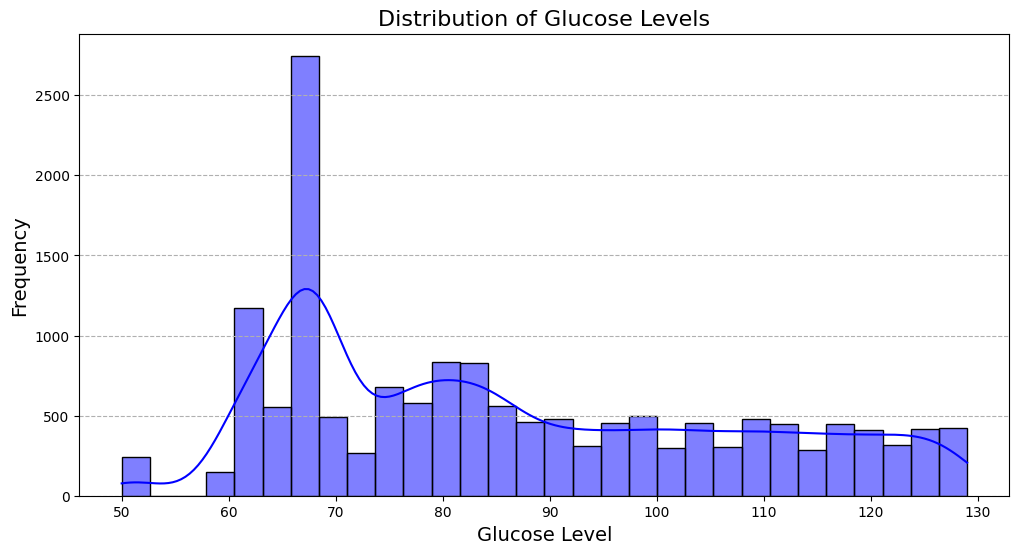

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Glucose Levels
plt.figure(figsize=(12, 6))
sns.histplot(data['Glucose_Level'], kde=True, color='blue', bins=30)
plt.title('Distribution of Glucose Levels', fontsize=16)
plt.xlabel('Glucose Level', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.show()

Correlation Heatmap

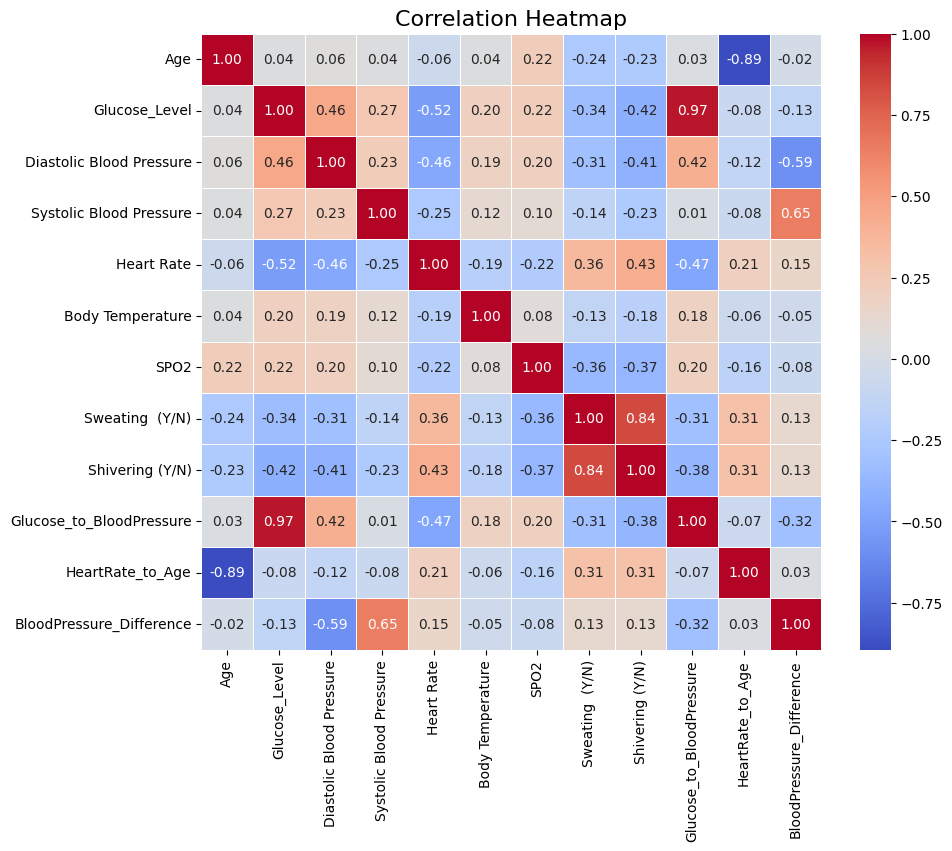

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Class Balance Check

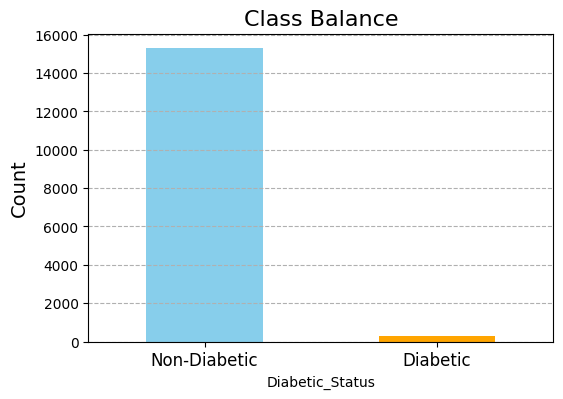

In [28]:
# Visualize class balance
plt.figure(figsize=(6, 4))
data['Diabetic_Status'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], rot=0)
plt.title('Class Balance', fontsize=16)
plt.xticks([0, 1], ['Non-Diabetic', 'Diabetic'], fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.show()

Prepare Data for Machine Learning

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target
X = data.drop(['Diabetic_Status', 'Age_Group'], axis=1).select_dtypes(include='number')
y = data['Diabetic_Status']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data prepared for Machine Learning!")

Data prepared for Machine Learning!


 Logistic Regression Model

In [30]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
print("Logistic Regression trained successfully!")

Logistic Regression trained successfully!


Random Forest Model

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest trained successfully!")

Random Forest trained successfully!


Model Evaluation

In [32]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Evaluate models
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")


Logistic Regression Evaluation:
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           D       0.99      1.00      1.00      3057
           N       1.00      0.53      0.69        59

    accuracy                           0.99      3116
   macro avg       1.00      0.76      0.84      3116
weighted avg       0.99      0.99      0.99      3116

Confusion Matrix:
[[3057    0]
 [  28   31]]

Random Forest Evaluation:
Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           D       1.00      1.00      1.00      3057
           N       1.00      0.88      0.94        59

    accuracy                           1.00      3116
   macro avg       1.00      0.94      0.97      3116
weighted avg       1.00      1.00      1.00      3116

Confusion Matrix:
[[3057    0]
 [   7   52]]


Hyperparameter Tuning for Random Forest

In [33]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                                   n_iter=50, cv=5, scoring='accuracy', random_state=42, verbose=2)
random_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {random_search.best_params_}")
best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.5s
[CV] END max_dep

Ensemble Learning with Voting Classifier

In [34]:
from sklearn.ensemble import VotingClassifier

# Combine models into a voting classifier
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model)], voting='soft')
ensemble_model.fit(X_train, y_train)
print("Ensemble Model Trained!")

Ensemble Model Trained!


Prepare Data for ARIMA

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Prepare data for ARIMA
glucose_series = data['Glucose_Level']

# Train-test split for ARIMA
train_size = int(len(glucose_series) * 0.8)
train, test = glucose_series[:train_size], glucose_series[train_size:]

print("Time-series data prepared for ARIMA!")

Time-series data prepared for ARIMA!


ARIMA Model

In [36]:
# Train ARIMA
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))
mse = mean_squared_error(test, arima_forecast)
print(f"ARIMA Mean Squared Error: {mse:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Mean Squared Error: 1248.26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Prepare Data for LSTM

In [37]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare data for LSTM
glucose_scaled = scaler.fit_transform(glucose_series.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(glucose_scaled)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build LSTM Model

In [38]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0609 - val_loss: 0.0479
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023 - val_loss: 0.0477
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0037 - val_loss: 0.0469
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0026 - val_loss: 0.0476
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023 - val_loss: 0.0473
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0014 - val_loss: 0.0467
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0018 - val_loss: 0.0504
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0027 - val_loss: 0.0465
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0019 - val_loss: 0.0467
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0021 - val_loss: 0.0471
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023 - val_loss: 0.0469
Epoch 12/20
390/390 ━━━━━━━━━━━━━━━━━━━━

Evaluate LSTM

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
LSTM Mean Squared Error: 0.05


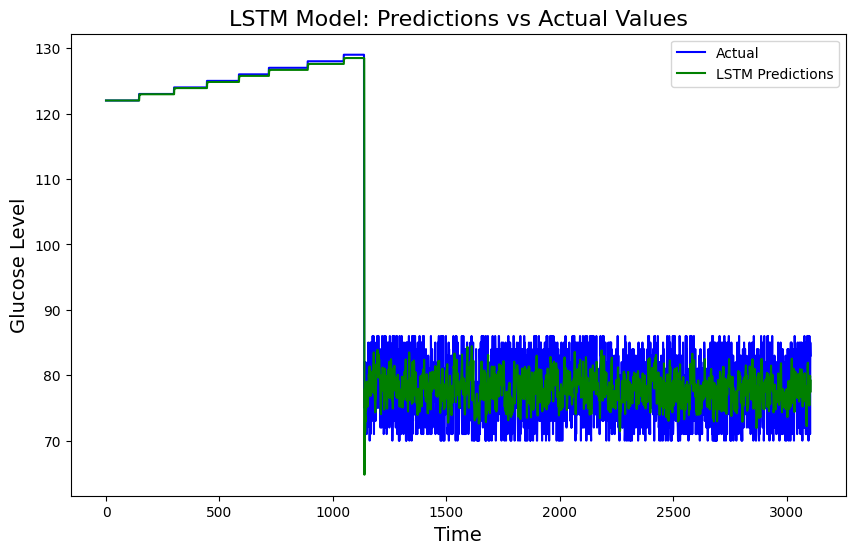

In [39]:
# Predict and evaluate LSTM
lstm_predictions = lstm_model.predict(X_test)
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, lstm_predictions)
print(f"LSTM Mean Squared Error: {mse:.2f}")

# Reverse scaling for actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_actual = scaler.inverse_transform(lstm_predictions)

# Plot LSTM Predictions vs Actual Values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(lstm_predictions_actual, label='LSTM Predictions', color='green')
plt.title('LSTM Model: Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Glucose Level', fontsize=14)
plt.legend()
plt.show()


Combine ARIMA and LSTM Predictions

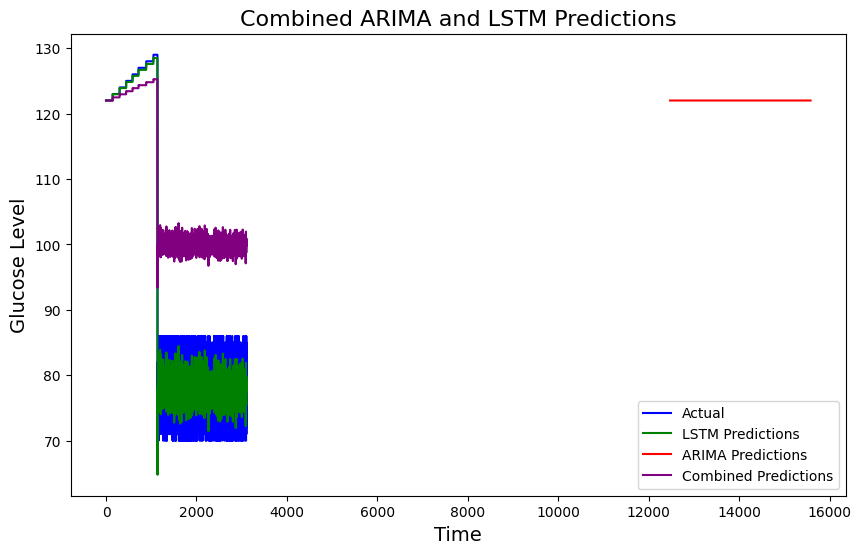

Combined Model Mean Squared Error: 326.34


In [40]:
# Combine ARIMA and LSTM Predictions
combined_predictions = (np.array(arima_forecast[-len(lstm_predictions_actual):]) + lstm_predictions_actual.flatten()) / 2

# Plot Combined Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(lstm_predictions_actual, label='LSTM Predictions', color='green')
plt.plot(arima_forecast[-len(y_test_actual):], label='ARIMA Predictions', color='red')
plt.plot(combined_predictions, label='Combined Predictions', color='purple')
plt.title('Combined ARIMA and LSTM Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Glucose Level', fontsize=14)
plt.legend()
plt.show()

# Evaluate Combined Model
from sklearn.metrics import mean_squared_error
combined_mse = mean_squared_error(y_test_actual, combined_predictions.reshape(-1, 1))
print(f"Combined Model Mean Squared Error: {combined_mse:.2f}")

Save Models for Deployment

In [42]:
import joblib

# Save the best Random Forest model
joblib.dump(best_rf_model, 'best_rf_model.pkl')
print("Best Random Forest model saved!")

# Save the LSTM model
lstm_model.save('lstm_model.h5')
print("LSTM model saved!")

# Save the Ensemble model
joblib.dump(ensemble_model, 'ensemble_model.pkl')
print("Ensemble model saved!")


Best Random Forest model saved!
LSTM model saved!
Ensemble model saved!
